In [8]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

np.random.seed(0)

import torch

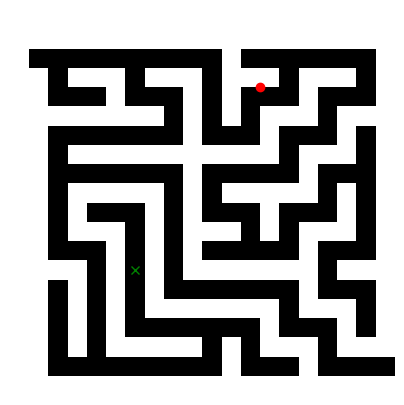

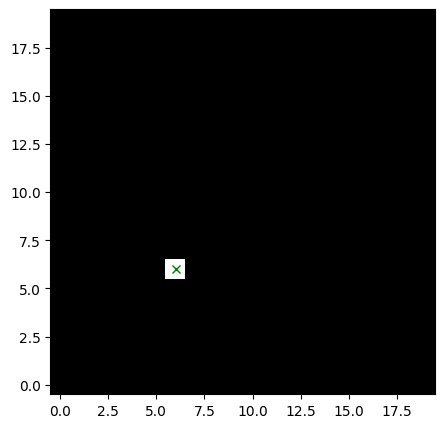

In [9]:
from maze_PTR_model import MazePTRModel
model = MazePTRModel()
checkpoint = torch.load("models/best_model.pt")
model.load_state_dict(checkpoint)
model.eval()

from maze_env import Maze
env = Maze(sparse=True)
env.plot()
env.plot_reward()

In [10]:
from deepQ import Agent
agent = Agent()

In [11]:
update_counter = 0
update_threshold = 100
losses = []
eps_anneal = True
final_greediness = 0.5
episode_length = 200
batch_size = 64
for episode in range(1000):
    print("Episode: ", episode)
    xt = env.reset_to_free_state()
    done = False
    for step in range(episode_length):
        # anneal the epsilon
        # calculate greediness.
        if eps_anneal:
            greediness = final_greediness*np.exp(1-episode_length/(step+1)) # rising exponential to the final greediness
        else:
            greediness = final_greediness
        at = agent.get_action(xt, 1-greediness)

        # take action
        xt1, rt1, done = env.step(at)

        # add to memory
        transition = (xt, at, xt1, rt1, done)
        agent.add_to_memory(transition)

        # train
        batch = agent.get_batch_from_memory(batch_size=batch_size)
        loss = agent.learn_step(batch)
        losses.append(loss)
        update_counter += 1

        # update the target network
        if update_counter == update_threshold:
            agent.update_target_network()
            update_counter = 0

        if done:
            break



Episode:  0
Episode:  1
Episode:  2
Episode:  3
Episode:  4
Episode:  5
Episode:  6
Episode:  7
Episode:  8
Episode:  9
Episode:  10
Episode:  11
Episode:  12
Episode:  13
Episode:  14
Episode:  15
Episode:  16
Episode:  17
Episode:  18
Episode:  19
Episode:  20
Episode:  21
Episode:  22
Episode:  23
Episode:  24
Episode:  25
Episode:  26
Episode:  27
Episode:  28
Episode:  29
Episode:  30
Episode:  31
Episode:  32
Episode:  33
Episode:  34
Episode:  35
Episode:  36
Episode:  37
Episode:  38
Episode:  39
Episode:  40
Episode:  41
Episode:  42
Episode:  43
Episode:  44
Episode:  45
Episode:  46
Episode:  47
Episode:  48
Episode:  49
Episode:  50
Episode:  51
Episode:  52
Episode:  53
Episode:  54
Episode:  55
Episode:  56
Episode:  57
Episode:  58
Episode:  59
Episode:  60
Episode:  61
Episode:  62
Episode:  63
Episode:  64
Episode:  65
Episode:  66
Episode:  67
Episode:  68
Episode:  69
Episode:  70
Episode:  71
Episode:  72
Episode:  73
Episode:  74
Episode:  75
Episode:  76
Episode: 

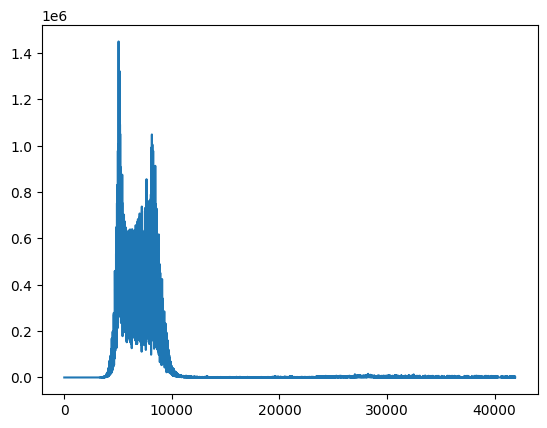

In [ ]:
plt.plot(losses)
plt.show()

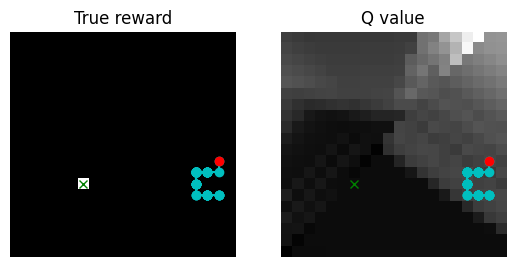

In [ ]:

# select the appropriate title
if env.sparse:
    reward_title = "True reward"
else:
    reward_title = "Expanded reward"

trajectory = [] # list of states visited in order
success = False

# produce a Q table
Q = np.zeros((env.Nx*env.Ny, len(env.action_space)))
s_table = torch.zeros((env.Nx*env.Ny, 2))
for i in range(env.Nx):
    for j in range(env.Ny):
        s_table[env.Ny*i+j, 0] = i
        s_table[env.Ny*i+j, 1] = j
Q = agent.model_main(s_table).detach().numpy()

state = env.reset_to_free_state()
for j in range(episode_length):

    # e-greedily select action
    a = agent.get_action(state, 0.3)

    # interact
    state, reward, done = env.step(a)
    trajectory.append(np.copy(state))

    s = np.copy(env.state)+0.5 # add 0.5 so that the dot shows up at the center of the grid
    plotting_trajectory = np.vstack(trajectory)+0.5 # add 0.5 so that the trajectory shows up at the center of the grid

    plt.subplot(1,2,1)
    plt.imshow(env.reward_landscape.T, origin="lower",extent=[0,env.Nx,0,env.Ny], cmap='gray')
    plt.plot(env.gx+0.5,env.gy+0.5,'gx') # goal location
    plt.title(reward_title)
    plt.plot(plotting_trajectory[:,0],plotting_trajectory[:,1],'c-o') # add 0.5 for plotting
    plt.plot(s[0],s[1],'ro') # agent location
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(np.max(Q,axis=1).reshape(env.Nx,env.Ny).T, origin="lower",extent=[0,env.Nx,0,env.Ny], cmap='gray')
    plt.plot(env.gx+0.5,env.gy+0.5,'gx') # goal location
    plt.title('Q estimate')
    plt.plot(plotting_trajectory[:,0],plotting_trajectory[:,1],'c-o') # add 0.5 for plotting
    plt.plot(s[0],s[1],'ro') # agent location
    plt.axis('off')
    plt.title("Q value")

    display.clear_output(wait=True)
    plt.show()

    # if the goal is reached, break
    if done:
        success = True
        break
